# PROPAGANDA CLASSIFICATION WITH UNCONTEXTUALIZED WORD EMBEDING - WORD2VEC

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# load data
train_data = pd.read_csv("/content/drive/MyDrive/ee278/ANLP assignment/propaganda_dataset_v2/propaganda_train.tsv", delimiter="\t")
test_data = pd.read_csv("/content/drive/MyDrive/ee278/ANLP assignment/propaganda_dataset_v2/propaganda_val.tsv", delimiter="\t")

## PREPROCESS DATA

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def preprocess(text):
    text = text.lower()
    
    # Remove punctuation, except for <>
    exclude = set(string.punctuation) - set('<>')
    text = ''.join(ch for ch in text if ch not in exclude)
  
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
  
    text = ' '.join(tokens)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
train_data['tagged_in_context'].apply(preprocess)

0                               < bos > < eos > confirmed
1       declassification effort < bos > ’ make things ...
2       obama administration misled < bos > american p...
3       “ looks like ’ capturing demise dark vortex < ...
4               < bos > location westerville ohio < eos >
                              ...                        
2409        < bos > support appreciate < eos > business ”
2410    international atomic energy agency iaea direct...
2411    done work formation year course ongoing format...
2412      < bos > law gradualness gradualness law < eos >
2413    jews described “ arrogant ” “ jealous ” “ < bo...
Name: tagged_in_context, Length: 2414, dtype: object

In [5]:
# Preprocess the data
train_sentences = [sentence.split() for sentence in train_data["tagged_in_context"].apply(preprocess)]
test_sentences = [sentence.split() for sentence in test_data["tagged_in_context"].apply(preprocess)]
train_labels = train_data["label"]
test_labels = test_data["label"]

In [6]:
train_sentences[1]

['declassification',
 'effort',
 '<',
 'bos',
 '>',
 '’',
 'make',
 'things',
 'worse',
 'president',
 'trump',
 '<',
 'eos',
 '>']

# TASK 1

In [7]:
# Map the labels to 0 or 1
train_labels_task1 = [0 if label=="not_propaganda" else 1 for label in train_labels]
test_labels_task1 = [0 if label=="not_propaganda" else 1 for label in test_labels]

In [8]:
#Train Word2Vec model
w2v_model = Word2Vec(train_sentences, vector_size=300, window=5, min_count=5, alpha=0.07)

In [9]:
#Define function to convert sentences to vectors using Word2Vec model
def sentence_to_vec(sentence, model):
    vec = np.zeros(300)
    count = 0
    for word in sentence:
        try:
            vec += model.wv[word]
            count += 1
        except KeyError:
            pass
    if count != 0:
        vec /= count
    return vec

In [10]:
#Convert sentences to vectors using Word2Vec model
train_embeddings = [sentence_to_vec(sentence, w2v_model) for sentence in train_sentences]
test_embeddings = [sentence_to_vec(sentence, w2v_model) for sentence in test_sentences]

In [11]:
# Train a logistic regression classifier for task 1
lr1 = LogisticRegression(random_state=42, C=0.1, max_iter=500, solver='lbfgs',penalty='l2')
lr1.fit(train_embeddings, train_labels_task1)
predictions = lr1.predict(test_embeddings)

# Get classification report
accuracy = accuracy_score(test_labels_task1, predictions)
report = classification_report(test_labels_task1, predictions, target_names=["not_propaganda", "propaganda"])
con_matrix = confusion_matrix(test_labels_task1, predictions)

In [12]:
# Print classification report
print("Task 1 Accuracy - Word2Vec: ", accuracy)
print("\nTask 1 Classification Report - Word2Vec:\n", report)
print("\nTask 1 Confusion Matrix -  Word2Vec:\n", con_matrix)

Task 1 Accuracy - Word2Vec:  0.6068965517241379

Task 1 Classification Report - Word2Vec:
                 precision    recall  f1-score   support

not_propaganda       0.62      0.61      0.62       301
    propaganda       0.59      0.61      0.60       279

      accuracy                           0.61       580
     macro avg       0.61      0.61      0.61       580
  weighted avg       0.61      0.61      0.61       580


Task 1 Confusion Matrix -  Word2Vec:
 [[183 118]
 [110 169]]


Task 1 Confusion Matrix - Word2Vec


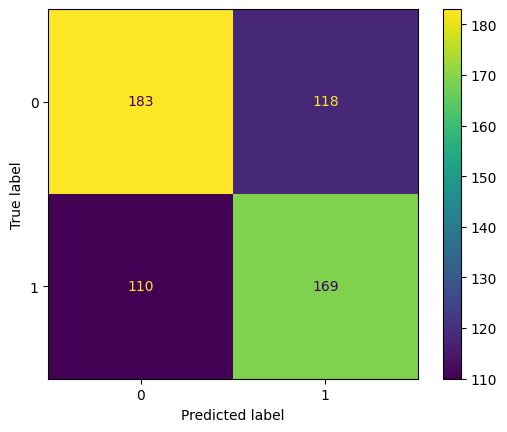

In [13]:
ConfusionMatrixDisplay.from_predictions(test_labels_task1, predictions)
print("Task 1 Confusion Matrix - Word2Vec")
plt.show()

# TASK 2

In [14]:
# Encode the labels for task 2
le = LabelEncoder()
train_labels_task2 = le.fit_transform(train_labels)
test_labels_task2 = le.fit_transform(test_labels)

In [15]:
# Train a logistic regression classifier for task 1
lr2 = LogisticRegression(random_state=42, multi_class='multinomial', C=0.1, max_iter=500, solver='lbfgs',penalty='l2', class_weight='balanced')
lr2.fit(train_embeddings, train_labels_task2)
predictions2 = lr2.predict(test_embeddings)

# Get Classification report
accuracy2 = accuracy_score(test_labels_task2, predictions2)
report2 = classification_report(test_labels_task2, predictions2, zero_division=1, target_names=le.classes_) 
con_matrix2 = confusion_matrix(test_labels_task2, predictions2)

In [16]:
# Print the results
print("Task 2 Accuracy - Word2vec: ", accuracy2)
print("\nTask 2 Classification Report - Word2Vec:\n", report2)
print("\nTask 2 Confusion Matrix - Word2Vec:\n", con_matrix2)


Task 2 Accuracy - Word2vec:  0.3603448275862069

Task 2 Classification Report - Word2Vec:
                            precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.10      0.02      0.04        43
causal_oversimplification       0.00      0.00      0.00        31
                    doubt       0.18      0.05      0.08        38
exaggeration,minimisation       1.00      0.00      0.00        28
              flag_waving       0.06      0.10      0.08        39
          loaded_language       0.07      0.05      0.06        37
    name_calling,labeling       0.08      0.42      0.14        31
           not_propaganda       0.62      0.62      0.62       301
               repetition       0.11      0.03      0.05        32

                 accuracy                           0.36       580
                macro avg       0.25      0.14      0.12       580
             weighted avg       0.41      0.36      0.35       580


Task 2 Confusion Matrix - Word2Vec

Task 2 Confusion Matrix - Word2Vec


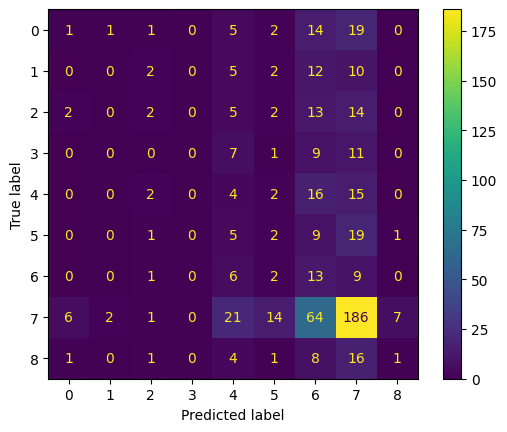

In [17]:
ConfusionMatrixDisplay.from_predictions(test_labels_task2, predictions2)
print("Task 2 Confusion Matrix - Word2Vec")
plt.show()


## REFERENCES

Sklearn Logistic Regression. https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Sklearn Classification report. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

Sklearn Confusion matrix. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

Sklearn Accuracy. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

Gensim model. https://radimrehurek.com/gensim/models/word2vec.html

Mimi Duta. https://www.analyticsvidhya.com/blog/2021/07/word2vec-for-word-embeddings-a-beginners-guide/